# Harris  角点检测器
---

https://en.wikipedia.org/wiki/Corner_detection#The_Harris_.26_Stephens_.2F_Plessey_.2F_Shi.E2.80.93Tomasi_corner_detection_algorithms

主要思想: 如果像素周围有多余一个方向的边,则认为是角点即兴趣点

将图像域中点 $x$ 上的对称半正定矩阵 $M_I = M_I(x)$ 定义为:

$$
M_I = \nabla I \nabla I^T = \left[\begin{matrix} I_x \\ I_y \end{matrix}\right] \left[\begin{matrix} I_x & I_y \end{matrix}\right] = \left[\begin{matrix} I_x^2 & I_x I_y \\ I_x I_y & I_y^2 \end{matrix}\right]
$$

$\nabla I$ 为包含导数 $I_x, I_y$ 的图像梯度, $M_I$ 秩为 1 特征值为 $\lambda_1=\abs{\nabla I}^2$ 和 $\lambda_2=0$.

选择权重矩阵 $W$ (通常为高斯滤波器 $G_{\theta}$),可得卷积:

$$
\bar{M_I} = W * M_I
$$

目的是得到 $M_I$ 在周围像素上的局部平均. $\bar{M_I}$ 称为 Harris 矩阵.

在不需要实际计算特征值的情况下,为了将重要的情况分离, Harris 和 Stephens 在[文献]()中引入指示函数:

$$
\det(\bar{M_I}) - k trace(\bar{M_I})^2
$$

为去除加权常数 $k$, 通常使用商数作为指示器:

$$
\frac{\det(\bar{M_I})}{trace(\bar{M_I})^2}
$$

In [1]:
%pylab inline
from sympy import init_printing
init_printing(use_latex='mathjax')
import os
os.chdir(os.path.join(os.curdir,'data'))

Populating the interactive namespace from numpy and matplotlib


In [13]:
from pylab import *
from scipy.ndimage import filters

def compute_harris_response(im,sigma=3):
    """ 在一副灰度图像中,对每个像素计算 Harris 角点检测响应函数"""
    
    # 计算导数
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
    
    # 计算 Harris 矩阵的分量
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)
    
    # 计算矩阵的权值和迹
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

先选取像素值高于阈值的所有图像点,再加上限制: 角点间的间隔必须大于设定的最小距离

In [14]:
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """ 从一副 Harris 响应图像 harrisim 中返回角点.
        min_dist 为分割角点和图像边界的最小像素数目
        threshold 为分割阈值
        """
    
    # 寻找高于阈值的候选点
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    # 获取候选点的坐标
    coords = array(harrisim_t.nonzero()).T
    
    # 获取候选点的 Harris 响应值
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    
    # 按照 Harris 响应值递减排序
    index = argsort(candidate_values)[::-1]
    
    # 将可行点的位置保存到数组
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # 按照相邻点最小距离大于 min_distance 的原则,选择最佳 Harris角点
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist), 
                        (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

In [15]:
# 添加中文字体支持
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\SimSun.ttc", size=14)

(800L, 569L)


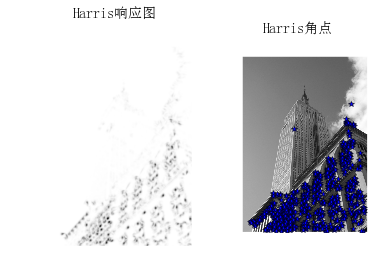

In [16]:
# 读入图像
im = array(Image.open('empire.jpg').convert('L'))

# 检测harris角点
harrisim = compute_harris_response(im)

# Harris响应函数
harrisim1 = 255 - harrisim

figure()
gray()

#画出Harris响应图
subplot(121)
imshow(harrisim1)
print harrisim1.shape
axis('off')
axis('equal')
title(u'Harris响应图', fontproperties=font)

subplot(122)
thres = 0.1
filtered_coords = get_harris_points(harrisim, 6, thres)
imshow(im)
plot([p[1] for p in filtered_coords],
            [p[0] for p in filtered_coords],'*')
axis('off')
title(u'Harris角点', fontproperties=font)

## 在图像间寻找对应点
---

Harris 角点的描述子通常由周围图像像素块的灰度值以及用于比较的归一化互相关矩阵构成.

两个同样大小像素块 $I_1(x), I_2(x)$ 的相关矩阵定义为:

$$
c(I_1,I_2) = \sum_x{f(I_1(x), I_2(x))}
$$

其中函数 $f$ 随相关方法变化, $x$ 为像素位置, 取 $ f(I_1(x), I_2(x)) = I_1 I_2 $  则有 $c(I_1,I_2) = I_1 \cdot I_2$, 
$c$ 越大,像素块相似度越大.归一化的互相关矩阵为:

$$
ncc(I_1,I_2) = \frac{1}{n-1}\sum_x{ \frac{I_1(x) - \mu_1}{\sigma_1} \cdot \frac{I_2(x) - \mu_2}{\sigma_2} }
$$

In [17]:
def get_descriptors(image,filtered_coords,wid=5):
    """ 对于每个点返回周围 2*wid+1 个像素的值,
    假定选取点的 min_distance > wid"""
    
    desc = []
    for coords in filtered_coords:
        patch = image[coords[0]-wid:coords[0]+wid+1,
                            coords[1]-wid:coords[1]+wid+1].flatten()
        desc.append(patch)
    
    return desc

In [18]:
def match(desc1,desc2,threshold=0.5):
    """ 对 desc1 图像中的每个角点描述子,使用归一化互相关,
    选取它在 desc2 图像中的匹配角点 """
    
    n = len(desc1[0])
    
    # pair-wise distances
    d = -ones((len(desc1),len(desc2)))
    for i in range(len(desc1)):
        for j in range(len(desc2)):
            d1 = (desc1[i] - mean(desc1[i])) / std(desc1[i])
            d2 = (desc2[j] - mean(desc2[j])) / std(desc2[j])
            ncc_value = sum(d1 * d2) / (n-1) 
            if ncc_value > threshold:
                d[i,j] = ncc_value
            
    ndx = argsort(-d)
    matchscores = ndx[:,0]
    
    return matchscores

In [19]:
def match_twosided(desc1,desc2,threshold=0.5):
    """ 两边对称版本的 match(). """
    
    matches_12 = match(desc1,desc2,threshold)
    matches_21 = match(desc2,desc1,threshold)
    
    ndx_12 = where(matches_12 >= 0)[0]
    
    # remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[matches_12[n]] != n:
            matches_12[n] = -1
    
    return matches_12

In [20]:
def appendimages(im1,im2):
    """ 返回将两幅图像并排拼接成的一副新图像 """
    
    # 选择具有较少行数的图像,然后填充足够的空行
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))),axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))),axis=0)
    # 如果这些情况都没有则说明他们的函数相同,不用填充
    
    return concatenate((im1,im2), axis=1)

In [21]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ 显示一副带有连接匹配之间连线的图片
        输入: im1,im2 (数组图像), locs1,locs2 (特征位置), 
        matchscores (match() 的输出), 
        show_below (是否将图像显示在匹配图像的下方. """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    
    imshow(im3)
    
    cols1 = im1.shape[1]
    for i,m in enumerate(matchscores):
        if m>0:
            plot([locs1[i][1],locs2[m][1]+cols1],[locs1[i][0],locs2[m][0]],'c')
    axis('off')

starting matching


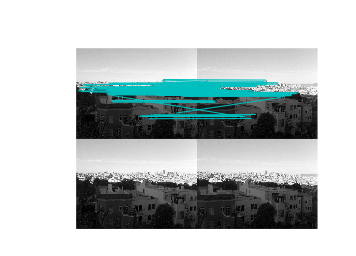

In [23]:
from pylab import *
from PIL import Image
from PCV.tools.imtools import imresize

"""
This is the Harris point matching example in Figure 2-2.
"""

# Figure 2-2上面的图
#im1 = array(Image.open("rans_1_small.jpg").convert("L"))
#im2 = array(Image.open("crans_2_small.jpg").convert("L"))

# Figure 2-2下面的图
im1 = array(Image.open("sf_view1.jpg").convert("L"))
im2 = array(Image.open("sf_view2.jpg").convert("L"))

# resize to make matching faster
im1 = imresize(im1, (im1.shape[1]/2, im1.shape[0]/2))
im2 = imresize(im2, (im2.shape[1]/2, im2.shape[0]/2))

wid = 5
harrisim = compute_harris_response(im1, 5)
filtered_coords1 = get_harris_points(harrisim, wid+1)
d1 = get_descriptors(im1, filtered_coords1, wid)

harrisim = compute_harris_response(im2, 5)
filtered_coords2 = get_harris_points(harrisim, wid+1)
d2 = get_descriptors(im2, filtered_coords2, wid)

print 'starting matching'
matches = match_twosided(d1, d2)

plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches)

### opencv
---
http://docs.opencv.org/2.4/doc/tutorials/features2d/trackingmotion/harris_detector/harris_detector.html

涉及函数:
[cornerHarris](http://docs.opencv.org/2.4.8/modules/imgproc/doc/feature_detection.html#cornerharris)

示例:
[C++示例](https://github.com/Itseez/opencv/blob/master/samples/cpp/tutorial_code/TrackingMotion/cornerHarris_Demo.cpp)

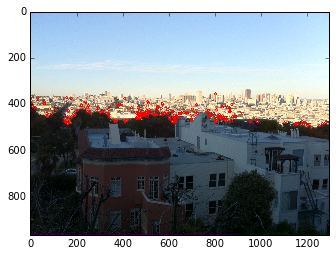

In [42]:
import cv2
rgbImg = array(Image.open("sf_view1.jpg"))
im = array(Image.open("sf_view1.jpg").convert("L"))

blockSize = 2
apertureSize = 3
k = 0.04
thresh = 5 # 阈值

imH = cv2.cornerHarris(im,blockSize,apertureSize,k)
imH = cv2.normalize(imH,0,255)
imH = cv2.convertScaleAbs(imH)
rows, cols = imH.shape
for j in range(rows):
    for i in range(cols):
        if imH[j,i] > thresh:
            cv2.circle(rgbImg,(i,j),5,(255,0,0),2,8,0)

imshow(rgbImg)

# SIFT(尺度不变特征变换)
---
Wiki:

https://zh.wikipedia.org/wiki/%E5%B0%BA%E5%BA%A6%E4%B8%8D%E8%AE%8A%E7%89%B9%E5%BE%B5%E8%BD%89%E6%8F%9B

https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

原书使用开源工具包 [VLFeat](http://www.vlfeat.org/), 但使用 opencv 的更好:

http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_sift_intro/py_sift_intro.html

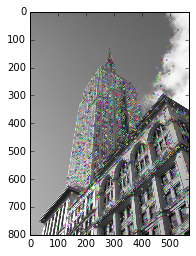

In [43]:
import cv2
import numpy as np

img = cv2.imread('empire.jpg')
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT()
kp = sift.detect(gray,None)

img=cv2.drawKeypoints(gray,kp)
imshow(img)

In [46]:
kp, des = sift.detectAndCompute(gray,None)
des.shape

(2803, 128)

In [49]:
len(kp)

2803

从实验看共找到 2803 个sift点,描述子为 128 维向量

In [51]:
def match(desc1,desc2):
    """ for each descriptor in the first image, 
    select its match in the second image.
    input: desc1 (descriptors for the first image), 
    desc2 (same for second image). """

    desc1 = array([d/linalg.norm(d) for d in desc1])
    desc2 = array([d/linalg.norm(d) for d in desc2])

    dist_ratio = 0.6
    desc1_size = desc1.shape
    
    matchscores = zeros((desc1_size[0],1))
    desc2t = desc2.T #precompute matrix transpose
    for i in range(desc1_size[0]):
        dotprods = dot(desc1[i,:],desc2t) #vector of dot products
        dotprods = 0.9999*dotprods
        #inverse cosine and sort, return index for features in second image
        indx = argsort(arccos(dotprods))
        
        #check if nearest neighbor has angle less than dist_ratio times 2nd
        if arccos(dotprods)[indx[0]] < dist_ratio * arccos(dotprods)[indx[1]]:
            matchscores[i] = int(indx[0])

    return matchscores

In [52]:
def match_twosided(desc1,desc2):
    """ two-sided symmetric version of match(). """
    
    matches_12 = match(desc1,desc2)
    matches_21 = match(desc2,desc1)
    
    ndx_12 = matches_12.nonzero()[0]
    
    #remove matches that are not symmetric
    for n in ndx_12:
        if matches_21[int(matches_12[n])] != n:
            matches_12[n] = 0

    return matches_12

In [53]:
def appendimages(im1,im2):
    """ return a new image that appends the two images side-by-side."""
    
    #select the image with the fewest rows and fill in enough empty rows
    rows1 = im1.shape[0]    
    rows2 = im2.shape[0]
    
    if rows1 < rows2:
        im1 = concatenate((im1,zeros((rows2-rows1,im1.shape[1]))), axis=0)
    elif rows1 > rows2:
        im2 = concatenate((im2,zeros((rows1-rows2,im2.shape[1]))), axis=0)
    #if none of these cases they are equal, no filling needed.
    
    return concatenate((im1,im2), axis=1)

In [54]:
def plot_matches(im1,im2,locs1,locs2,matchscores,show_below=True):
    """ show a figure with lines joining the accepted matches
        input: im1,im2 (images as arrays), locs1,locs2 (location of features), 
        matchscores (as output from 'match'), show_below (if images should be shown below). """
    
    im3 = appendimages(im1,im2)
    if show_below:
        im3 = vstack((im3,im3))
    
    # show image
    imshow(im3)
    
    # draw lines for matches
    cols1 = im1.shape[1]
    for i in range(len(matchscores)):
        if matchscores[i] > 0:
            plot([locs1[i,0], locs2[matchscores[i,0],0]+cols1], [locs1[i,1], locs2[matchscores[i,0],1]], 'c')
    axis('off')


In [ ]:
from PCV.localdescriptors import sift

"""
This is the twosided SIFT feature matching example from Section 2.2 (p 44).
"""

imname1 = 'climbing_1_small.jpg'
imname2 = 'climbing_2_small.jpg'

# process and save features to file
#sift.process_image(imname1, 'climbing_1_small.sift')
#sift.process_image(imname2, 'climbing_2_small.sift')

sift.process_image(imname1, imname1+'.sift')
sift.process_image(imname2, imname2+'.sift')

# read features and match
l1, d1 = sift.read_features_from_file('climbing_1_small.sift')
l2, d2 = sift.read_features_from_file('climbing_2_small.sift')
#matchscores = sift.match(d1, d2)
matchscores = sift.match_twosided(d1, d2)

# load images and plot
im1 = array(Image.open(imname1))
im2 = array(Image.open(imname2))

sift.plot_matches(im1, im2, l1, l2, matchscores, show_below=True)
show()